### Import Required Libraries
In this cell, we import all necessary Python libraries for data handling, visualization, machine learning model building, evaluation, and advanced algorithms like XGBoost.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

DATASET_FILENAME = "heart.csv"

In [3]:
# Load the dataset
if not os.path.exists(DATASET_FILENAME):
    raise FileNotFoundError(f"'{DATASET_FILENAME}' not found in current directory.")

df = pd.read_csv(DATASET_FILENAME)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Basic information about the dataset
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina

In [5]:
# Descriptive statistics for numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### Target Variable Analysis
In this cell, we verify the presence of the target column (`HeartDisease`), calculate its class distribution (counts and percentages), and visualize the balance between healthy and diseased patients using a count plot.

Class counts:
HeartDisease
1    508
0    410
Name: count, dtype: int64

Class percentages:
HeartDisease
1    55.337691
0    44.662309
Name: proportion, dtype: float64


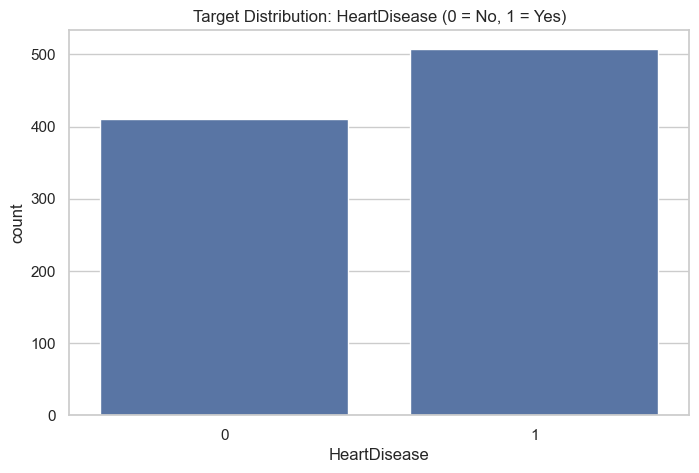

In [6]:
target_col = "HeartDisease"

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

# Count and percentage
counts = df[target_col].value_counts()
percentages = df[target_col].value_counts(normalize=True) * 100

print("Class counts:")
print(counts)
print("\nClass percentages:")
print(percentages)

# Plot class distribution
plt.figure()
sns.countplot(x=target_col, data=df)
plt.title("Target Distribution: HeartDisease (0 = No, 1 = Yes)")
plt.show()


### Feature Type Identification
In this cell, we automatically separate numerical and categorical features from the dataset and remove the target variable from the numerical feature list to prepare for proper EDA and preprocessing.

In [ ]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Remove target from numeric_cols if present
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


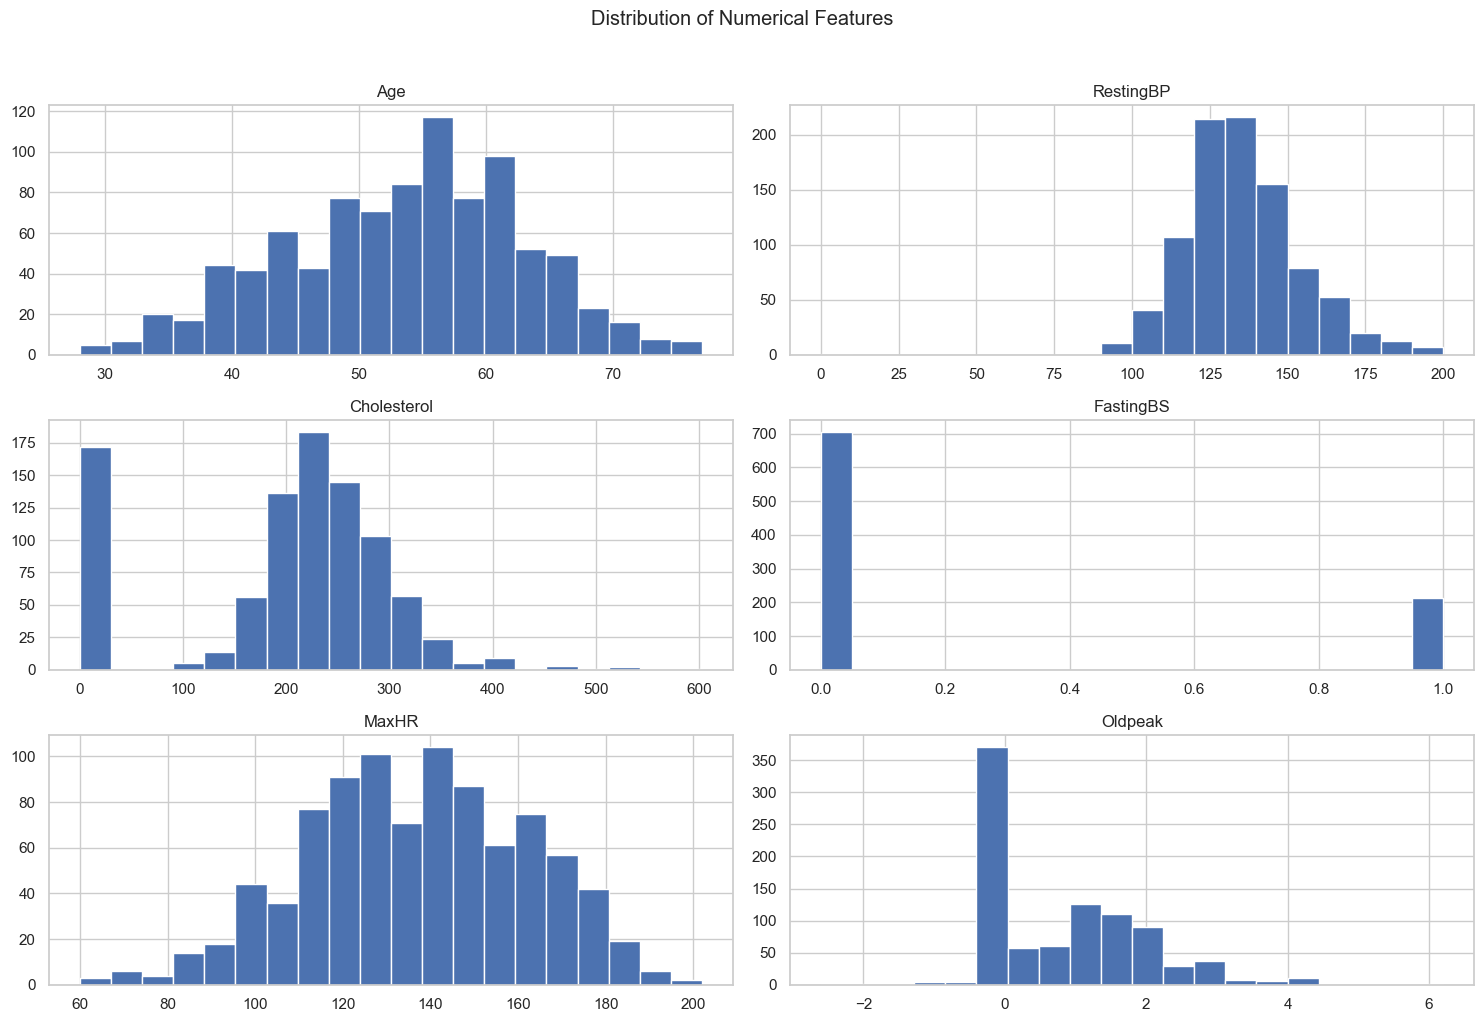

In [8]:
# Histograms of numerical features
df[numeric_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle("Distribution of Numerical Features", y=1.02)
plt.tight_layout()
plt.show()


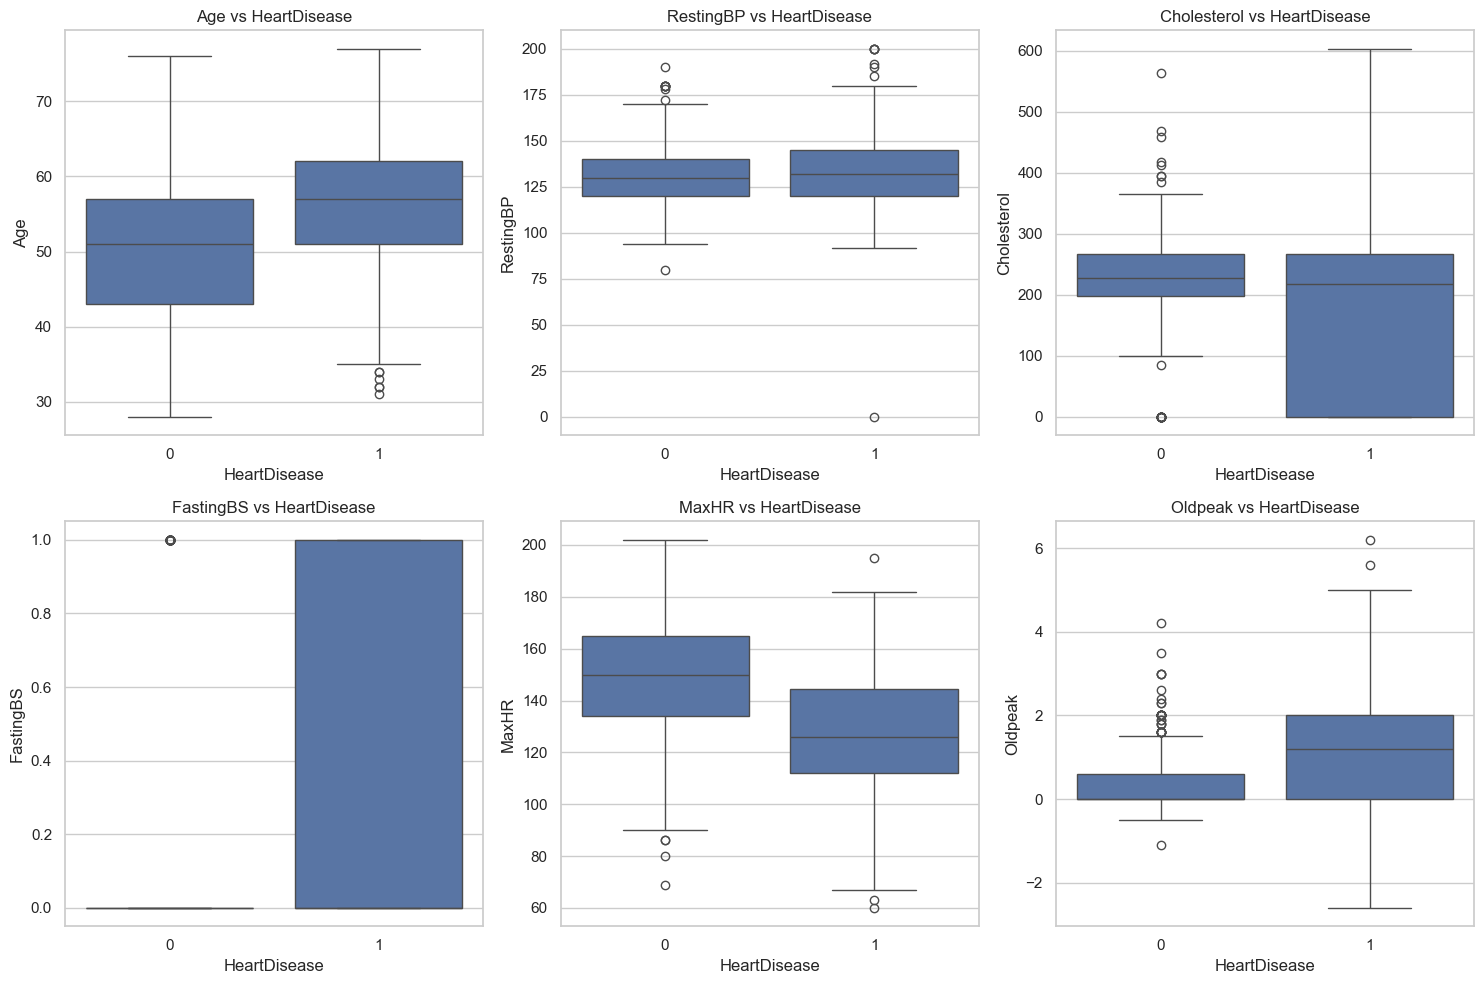

In [9]:
# Boxplots for numerical features vs target
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df, x=target_col, y=col)
    plt.title(f"{col} vs {target_col}")

plt.tight_layout()
plt.show()

### Categorical Feature Distribution Visualization
In this cell, we visualize the distribution of all categorical features using count plots and compare each category against the target variable (`HeartDisease`) to observe class-wise patterns.

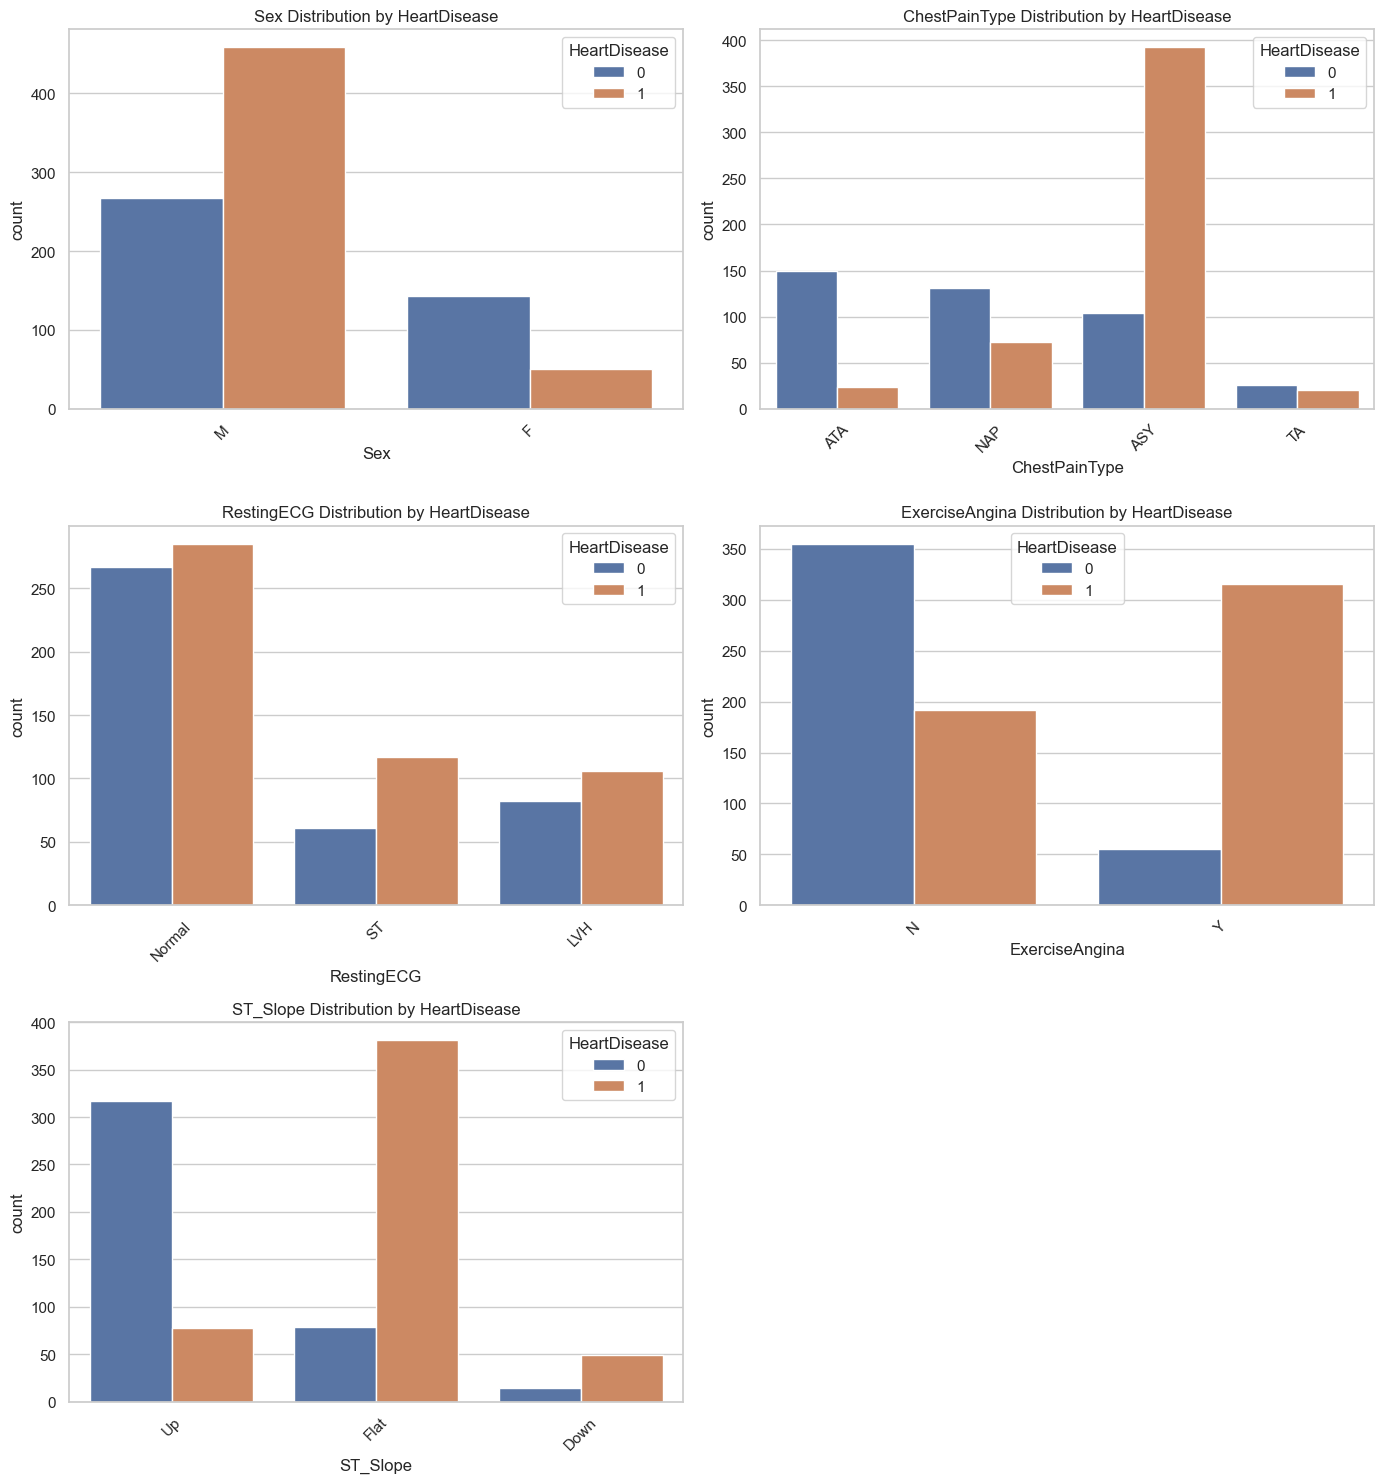

In [10]:
if len(categorical_cols) > 0:
    n_cols = 2
    n_rows = int(np.ceil(len(categorical_cols) / n_cols))

    plt.figure(figsize=(14, 5 * n_rows))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.countplot(data=df, x=col, hue=target_col)
        plt.title(f"{col} Distribution by {target_col}")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns detected.")

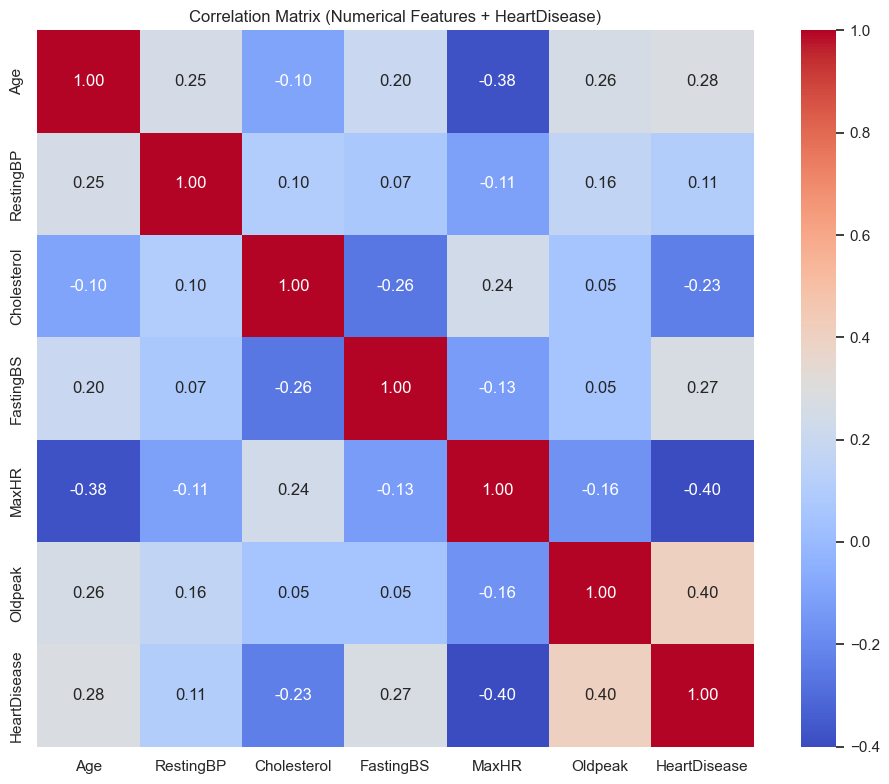

In [11]:
# Correlation matrix including the target
corr = df[numeric_cols + [target_col]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Numerical Features + HeartDisease)")
plt.tight_layout()
plt.show()


### Feature Engineering
In this cell, we create new derived features such as squared values and ratio-based metrics to capture non-linear relationships and improve the predictive power of the machine learning models.


In [12]:
df_fe = df.copy()

# Feature engineering similar to heart_failure_prediction.py
df_fe["Oldpeak_squared"] = df_fe["Oldpeak"] ** 2
df_fe["MaxHR_Age_Ratio"] = df_fe["MaxHR"] / df_fe["Age"]
df_fe["Cholesterol_Age_Ratio"] = df_fe["Cholesterol"] / df_fe["Age"]
df_fe["RestingBP_Age_Ratio"] = df_fe["RestingBP"] / df_fe["Age"]

print("New columns added:")
for col in ["Oldpeak_squared", "MaxHR_Age_Ratio", "Cholesterol_Age_Ratio", "RestingBP_Age_Ratio"]:
    print("-", col)

df_fe.head()

New columns added:
- Oldpeak_squared
- MaxHR_Age_Ratio
- Cholesterol_Age_Ratio
- RestingBP_Age_Ratio


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Oldpeak_squared,MaxHR_Age_Ratio,Cholesterol_Age_Ratio,RestingBP_Age_Ratio
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.00,4.300000,7.225000,3.500000
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,1.00,3.183673,3.673469,3.265306
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,0.00,2.648649,7.648649,3.513514
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,2.25,2.250000,4.458333,2.875000
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0.00,2.259259,3.611111,2.777778


### Feature–Target Separation and Encoding
In this cell, we separate the input features from the target variable and apply one-hot encoding to categorical features so that the dataset becomes fully numerical and ready for machine learning.


In [13]:
# Separate features and target
y = df_fe[target_col].astype(int)
X = df_fe.drop(columns=[target_col])

# One-hot encode categorical features
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns being encoded:", cat_cols)

X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

feature_names = X_encoded.columns.tolist()
print(f"Total number of features after encoding and engineering: {len(feature_names)}")

X_encoded.head()


Categorical columns being encoded: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Total number of features after encoding and engineering: 19


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Oldpeak_squared,MaxHR_Age_Ratio,Cholesterol_Age_Ratio,RestingBP_Age_Ratio,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0.00,4.300000,7.225000,3.500000,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1.00,3.183673,3.673469,3.265306,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0.00,2.648649,7.648649,3.513514,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,2.25,2.250000,4.458333,2.875000,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0.00,2.259259,3.611111,2.777778,True,False,True,False,True,False,False,False,True


### Feature Scaling
In this cell, we standardize all input features using `StandardScaler` so that they have a mean of 0 and standard deviation of 1, ensuring fair contribution of all features to the machine learning models.

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

X_scaled.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Oldpeak_squared,MaxHR_Age_Ratio,Cholesterol_Age_Ratio,RestingBP_Age_Ratio,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432,-0.553294,1.823200,1.463847,1.792436,0.515952,2.075177,-0.532838,-0.229679,0.814275,-0.490449,-0.823556,-1.002181,1.150674
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664,-0.265682,0.563298,-0.091453,1.352558,-1.938163,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.823556,0.997824,-0.869056
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432,-0.553294,-0.040539,1.649373,1.817763,0.515952,2.075177,-0.532838,-0.229679,-1.228087,2.038947,-0.823556,-1.002181,1.150674
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711,0.093834,-0.490460,0.252258,0.621023,-1.938163,-0.481887,-0.532838,-0.229679,0.814275,-0.490449,1.214246,0.997824,-0.869056
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432,-0.553294,-0.480010,-0.118761,0.438804,0.515952,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.823556,-1.002181,1.150674


### Train–Test Data Split
In this cell, we split the scaled dataset into training and testing sets while preserving class distribution using stratification, so that model evaluation remains unbiased and reliable.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:    ", X_test.shape[0])


Training set size: 734
Test set size:     184


### Model Training and Ensemble Learning
In this cell, we train four different machine learning models and combine them into a soft-voting ensemble to improve overall prediction performance and robustness.

**Purpose of each model (1-line each):**
- **Logistic Regression:** A fast and interpretable baseline model for binary classification.
- **Random Forest:** An ensemble of decision trees that captures non-linear patterns and reduces overfitting.
- **XGBoost:** A powerful gradient-boosting model optimized for high predictive accuracy.
- **SVM (RBF Kernel):** A margin-based classifier effective for complex non-linear decision boundaries.
- **Voting Ensemble:** Combines all models’ predictions to achieve more stable and accurate results.


In [18]:
# 1. Logistic Regression
model_lr = LogisticRegression(
    random_state=42,
    max_iter=2000,
    class_weight="balanced",
    C=0.1
)
model_lr.fit(X_train, y_train)

# 2. Random Forest - fixed "good" hyperparameters instead of RandomizedSearchCV
model_rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_estimators=300,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
)
model_rf.fit(X_train, y_train)

# 3. XGBoost - fixed "good" hyperparameters (no RandomizedSearchCV)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_xgb = XGBClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    n_jobs=1,                 # avoids multiprocessing bugs
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

model_xgb.fit(X_train, y_train)


# 4. SVM (RBF kernel)
model_svm = SVC(
    probability=True,
    random_state=42,
    class_weight="balanced",
    kernel="rbf",
    C=1.0
)
model_svm.fit(X_train, y_train)

# 5. Ensemble Voting Classifier
model_ensemble = VotingClassifier(
    estimators=[
        ("lr", model_lr),
        ("rf", model_rf),
        ("xgb", model_xgb),
        ("svm", model_svm),
    ],
    voting="soft"
)
model_ensemble.fit(X_train, y_train)

print("All models trained successfully.")


All models trained successfully.


### Model Evaluation and Performance Comparison
In this cell, we evaluate each trained model on the test dataset using precision, recall, F1-score, and accuracy, and compile a summary table to compare the overall performance of all models side by side.

In [19]:
models = {
    "Logistic Regression": model_lr,
    "Random Forest (Tuned)": model_rf,
    "XGBoost (Tuned)": model_xgb,
    "SVM": model_svm,
    "Ensemble (Voting)": model_ensemble
}

summary_rows = []

for name, model in models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    report = classification_report(
        y_test, y_pred,
        target_names=["Normal (0)", "Heart Disease (1)"],
        output_dict=True
    )
    print(classification_report(y_test, y_pred, target_names=["Normal (0)", "Heart Disease (1)"]))

    summary_rows.append({
        "Model": name,
        "Accuracy (%)": round(report["accuracy"] * 100, 2),
        "F1 (Class 0)": round(report["Normal (0)"]["f1-score"], 3),
        "F1 (Class 1)": round(report["Heart Disease (1)"]["f1-score"], 3),
        "Macro F1": round(report["macro avg"]["f1-score"], 3),
    })

summary_df = pd.DataFrame(summary_rows).set_index("Model")
summary_df



=== Logistic Regression ===
                   precision    recall  f1-score   support

       Normal (0)       0.90      0.88      0.89        82
Heart Disease (1)       0.90      0.92      0.91       102

         accuracy                           0.90       184
        macro avg       0.90      0.90      0.90       184
     weighted avg       0.90      0.90      0.90       184


=== Random Forest (Tuned) ===
                   precision    recall  f1-score   support

       Normal (0)       0.87      0.83      0.85        82
Heart Disease (1)       0.87      0.90      0.88       102

         accuracy                           0.87       184
        macro avg       0.87      0.87      0.87       184
     weighted avg       0.87      0.87      0.87       184


=== XGBoost (Tuned) ===
                   precision    recall  f1-score   support

       Normal (0)       0.83      0.88      0.85        82
Heart Disease (1)       0.90      0.85      0.87       102

         accuracy     

,Accuracy (%),F1 (Class 0),F1 (Class 1),Macro F1
Model,,,,
Logistic Regression,90.22,0.889,0.913,0.901
Random Forest (Tuned),86.96,0.850,0.885,0.867
XGBoost (Tuned),86.41,0.852,0.874,0.863
SVM,90.76,0.893,0.919,0.906
Ensemble (Voting),89.67,0.883,0.907,0.895


### Confusion Matrix Visualization
In this cell, we generate and display confusion matrix heatmaps for each trained model to visually analyze correct and incorrect classifications on the test dataset.


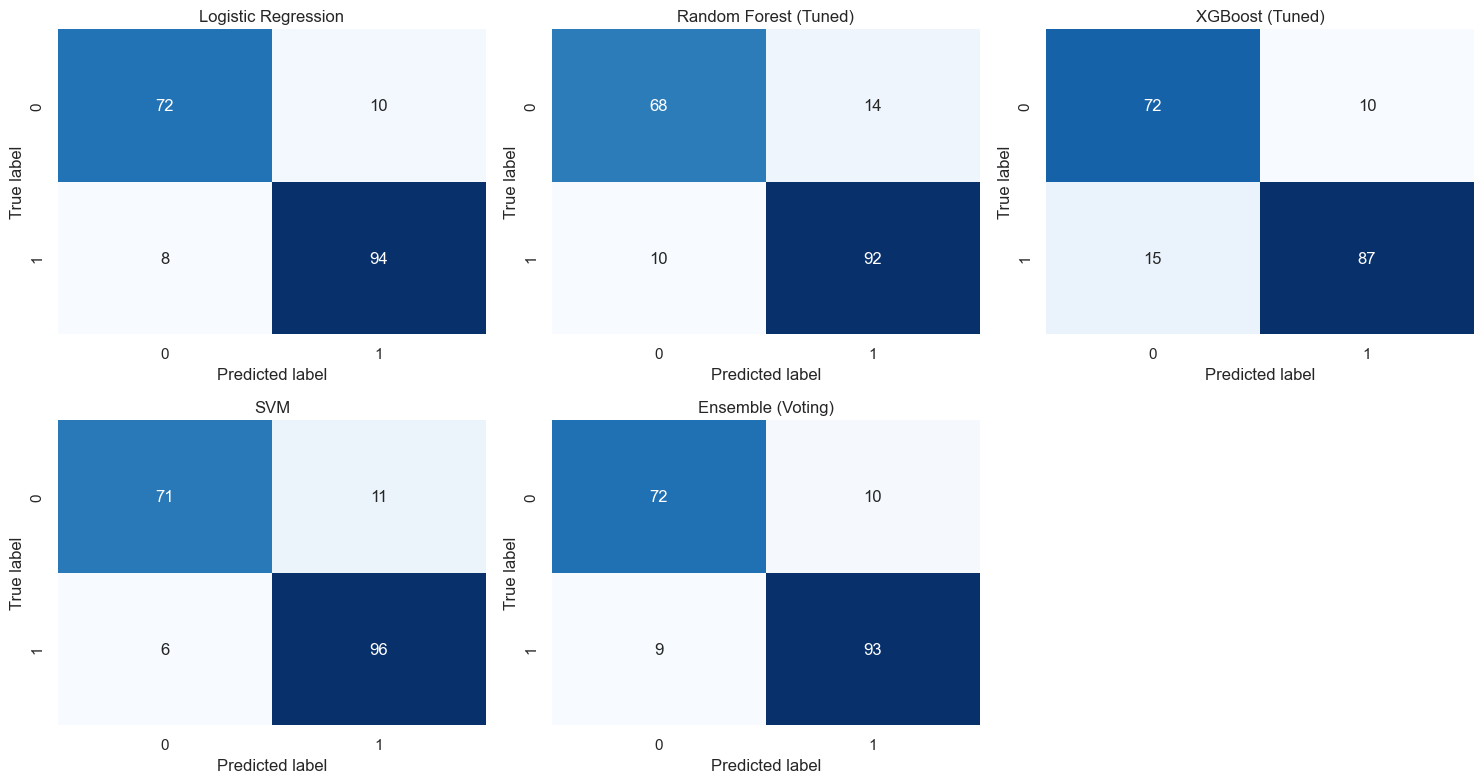

In [20]:
from itertools import product

n_models = len(models)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(n_rows, n_cols, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(name)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plt.tight_layout()
plt.show()


### ROC Curve and AUC Comparison
In this cell, we plot the ROC curves and compute the AUC scores for all models to compare their ability to distinguish between heart disease and normal cases across different classification thresholds.


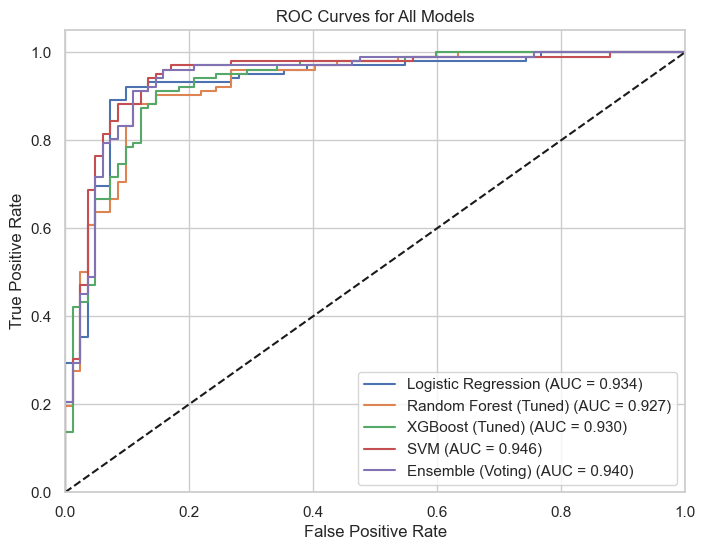

In [21]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Some models (e.g. SVM) need predict_proba or decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.show()


### Feature Importance Analysis (Random Forest)
In this cell, we extract and visualize feature importance scores from the trained Random Forest model to identify which features contribute the most to heart disease prediction.


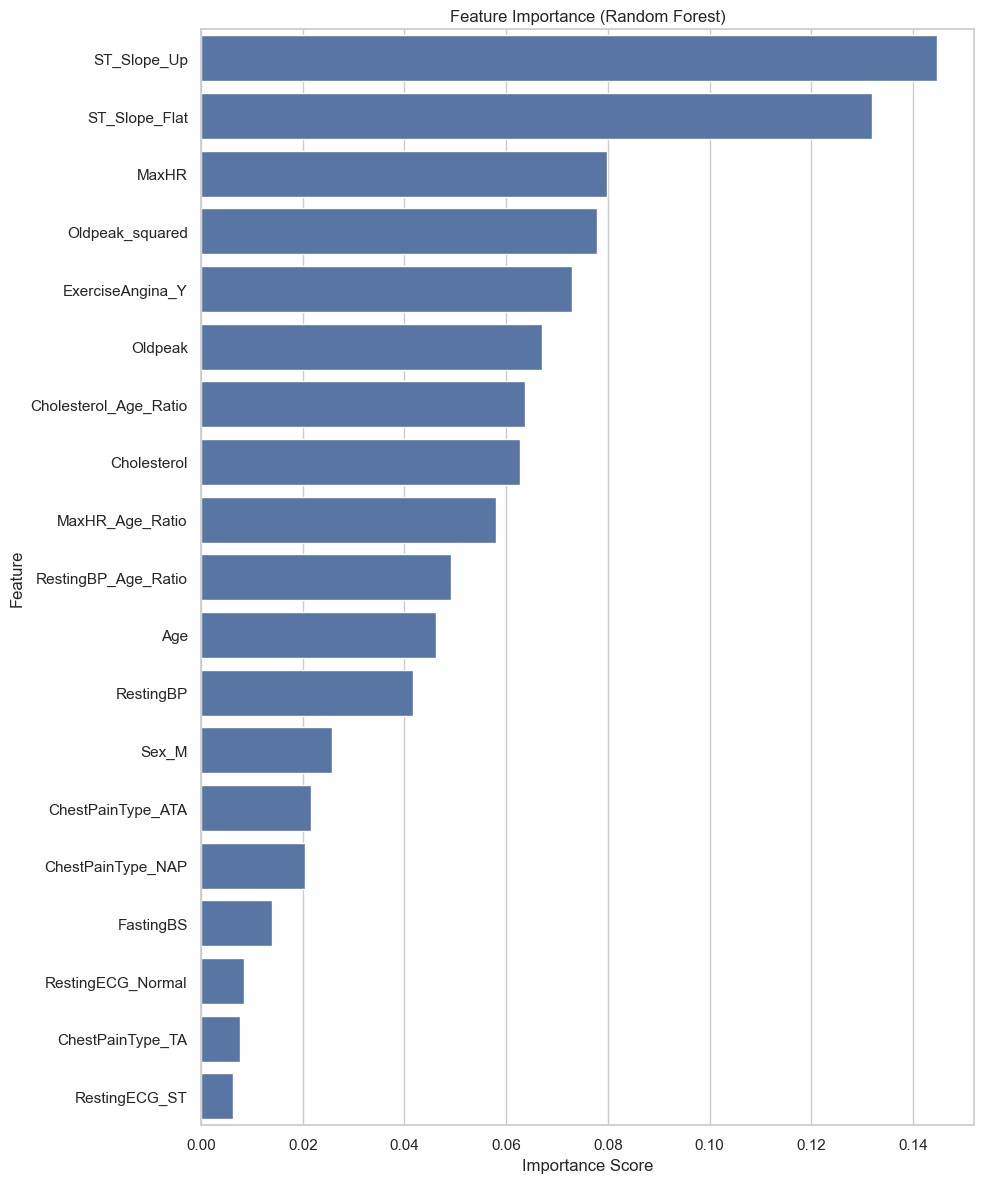

,feature,importance
18,ST_Slope_Up,0.144740
17,ST_Slope_Flat,0.131855
4,MaxHR,0.079864
6,Oldpeak_squared,0.077867
16,ExerciseAngina_Y,0.072865
5,Oldpeak,0.067030
8,Cholesterol_Age_Ratio,0.063750
2,Cholesterol,0.062720
7,MaxHR_Age_Ratio,0.057975
9,RestingBP_Age_Ratio,0.049210


In [27]:
importances = pd.DataFrame({
    "feature": feature_names,
    "importance": model_rf.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(data=importances, x="importance", y="feature")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

importances.head(20)